# Generative Adversarial Network

Training GAN from a Gaussian Normal Distribution

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

## Gaussian Normal Distribution

Normal distribution with mean 1 and variance -1

In [2]:
MU, SIGMA = -1, 1

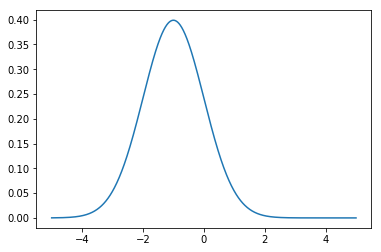

In [3]:
linspace = np.linspace(-5, 5, 1000)
gaussian = norm.pdf(linspace, loc=MU, scale=SIGMA)
plt.plot(linspace, gaussian)

## Define Sample and Noise

Random noise from uniform distribution and samples from normal distribution

In [4]:
def sample(size):
    noise = np.random.uniform(-5, 5, size)
    noise.sort()
    normal = norm.pdf(noise, loc=MU, scale=SIGMA)
    return np.reshape(normal, [-1, 1])

In [5]:
def noise(size):
    noise = np.random.uniform(-1, 1, size)
    noise.sort()
    return np.reshape(noise, [-1, 1])

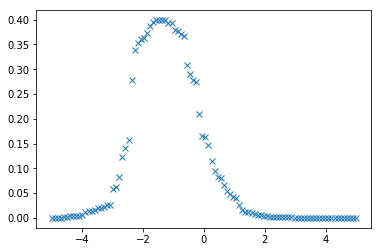

In [6]:
linspace = np.linspace(-5, 5, 100)
normal = sample(100)
plt.plot(linspace, normal, 'x')

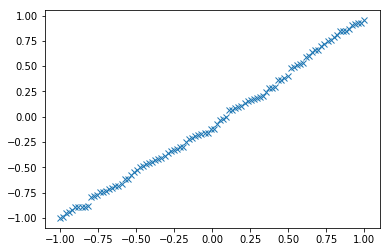

In [7]:
linspace = np.linspace(-1, 1, 100)
noise_data = noise(100)
plt.plot(linspace, noise_data, 'x')

## Create Generative Adversarial Nets

Optimize generator and discriminator with AdamOptimizer

In [8]:
STEP = 3
TRAIN_ITER = 100
BATCH_SIZE = 200

In [9]:
def leaky_relu(layer):
    return tf.maximum(0.2*layer, layer) 

def batch_norm(layer, name='norm', epsilon=1e-3):
    with tf.variable_scope(name):
        size = layer.get_shape().as_list()[1]
        mean, var = tf.nn.moments(layer, [0])
        
        scale = tf.get_variable('gamma', [size], initializer=tf.random_normal_initializer())
        shift = tf.get_variable('beta', [size], initializer=tf.random_normal_initializer())
        
        norm = tf.nn.batch_normalization(layer, mean, var, shift, scale, epsilon)
    
    return norm

In [10]:
def generator(batch, drop_rate, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
        w1 = tf.get_variable('w1', [1, 128], 
                            initializer=tf.random_normal_initializer())
        w2 = tf.get_variable('w2', [128, 128], 
                            initializer=tf.random_normal_initializer())
        w3 = tf.get_variable('w3', [128, 1],
                            initializer=tf.random_normal_initializer()) # output (x, y)

        l1 = batch_norm(tf.matmul(z_batch, w1), name='norm1')
        l1 = tf.nn.dropout(leaky_relu(l1), drop_rate)

        l2 = batch_norm(tf.matmul(l1, w2), name='norm2')
        l2 = tf.nn.dropout(leaky_relu(l2), drop_rate)

        l3 = batch_norm(tf.matmul(l2, w3), name='norm3')
        l3 = tf.nn.sigmoid(l3)

    return l3

In [11]:
def discriminator(batch, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        w1 = tf.get_variable('w1', [1, 128],
                            initializer=tf.random_normal_initializer())
        w2 = tf.get_variable('w2', [128, 128],
                            initializer=tf.random_normal_initializer())
        w3 = tf.get_variable('w3', [128, 1],
                            initializer=tf.random_normal_initializer())
        
        l1 = batch_norm(tf.matmul(batch, w1), name='norm1')
        l1 = leaky_relu(l1)
        
        l2 = batch_norm(tf.matmul(l1, w2), name='norm2')
        l2 = leaky_relu(l2)
        
        l3 = batch_norm(tf.matmul(l2, w3), name='norm3')
        l3 = tf.nn.sigmoid(l3) # sigmoid range : 0 ~ 1 = it can be used as a probability
        
    return l3

In [12]:
drop_rate = tf.placeholder(tf.float32)
z_batch = tf.placeholder(tf.float32, [None, 1]) # uniform (-1, 1) distribution
x_batch = tf.placeholder(tf.float32, [None, 1]) # gaussian (-1, 1) distribution

In [13]:
G = generator(z_batch, drop_rate)
    
D1 = discriminator(x_batch)
D2 = discriminator(G, reuse=True)

In [14]:
g_weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')
d_weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')

In [15]:
# max[log(D(G(z)))] = min[1 - log(D(G(z)))]
lost_g = tf.reduce_mean(tf.log(D2)) # train only generator weights
opt_g = tf.train.AdamOptimizer(1e-2).minimize(1-lost_g, var_list=g_weights) 

In [16]:
# p(D) = log(D(x)) + log(1-D(G(z))))
# max[p(D)] = min[1 - p(D)]
lost_d = tf.reduce_mean(tf.log(D1) + tf.log(1 - D2)) # train only discriminator weights
opt_d = tf.train.AdamOptimizer(1e-2).minimize(1-lost_d, var_list=d_weights)

## Train generator, discriminator

Train generator and discriminator with batch step

In [17]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [18]:
d_loss = np.zeros([TRAIN_ITER])
g_loss = np.zeros([TRAIN_ITER])

In [19]:
for i in range(TRAIN_ITER):
    for step in range(STEP): # train discriminator with STEP steps
        x = sample(BATCH_SIZE)
        z = noise(BATCH_SIZE)
    
        d_loss[i], _ = sess.run([lost_d, opt_d], feed_dict={x_batch: x, z_batch: z, drop_rate: 0.5})
    
    z = noise(BATCH_SIZE)
    g_loss[i], _ = sess.run([lost_g, opt_g], feed_dict={z_batch: z, drop_rate: 0.5})
    
    if i % (TRAIN_ITER // 10) == 0:
        print('ITER : ', i / TRAIN_ITER)

print('ITER : ', 1.0)

ITER :  0.0
ITER :  0.1
ITER :  0.2
ITER :  0.3
ITER :  0.4
ITER :  0.5
ITER :  0.6
ITER :  0.7
ITER :  0.8
ITER :  0.9
ITER :  1.0


## Plot graph

Plot object function loss and generating samples

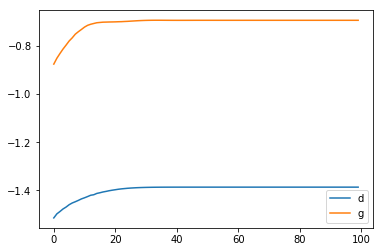

In [20]:
plt.plot(d_loss, label='d')
plt.plot(g_loss, label='g')
plt.legend()

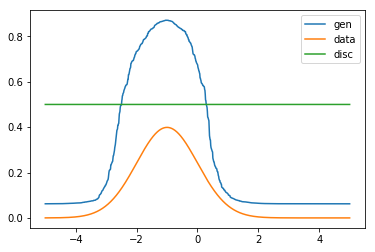

In [21]:
linspace = np.linspace(-5, 5, 1000)
data = norm.pdf(linspace, loc=MU, scale=SIGMA)

noise_sample = sample(1000)

gen = sess.run(G, feed_dict={z_batch: noise_sample, drop_rate: 1.0})
disc = sess.run(D1, feed_dict={x_batch: gen})

plt.plot(linspace, gen, label='gen')
plt.plot(linspace, data, label='data')
plt.plot(linspace, disc, label='disc')
plt.legend()

In [22]:
sess.close()